# Lesson 3. Access PRISM datasets and visualize climate data in 3d with `lexcube`

### Step 1. List all objects inside an AWS S3 bucket

In [1]:
from s3fs import S3FileSystem

# Instantiate the filesystem for a public bucket
s3 = S3FileSystem(anon=True)

# Define the S3 URI (path)
s3_uri = 's3://ocs-training-2026/advanced/'

# List all files and subdirectories
all_files_and_dirs = s3.ls(s3_uri)
print(all_files_and_dirs)

['ocs-training-2026/advanced/', 'ocs-training-2026/advanced/PRISM', 'ocs-training-2026/advanced/climate.zarr', 'ocs-training-2026/advanced/random_data.zarr', 'ocs-training-2026/advanced/s2_nir_cog.tif']


### Step 2. Get a list of GeoTIFF files from an S3 folder 

To get a list of all .tif files inside a specific S3 "folder" (prefix), you need to use the **boto3** library to list all objects with the specified prefix and then filter the results client-side to keep only those ending with .tif. S3 does not support filtering by suffix on the service end.

In [2]:
import boto3

def list_tif_files_in_s3_folder(bucket_name, folder_prefix):
    """
    Lists all .tif files within a specific folder prefix in an S3 bucket.

    :param bucket_name: The name of the S3 bucket.
    :param folder_prefix: The 'folder' path (prefix) within the bucket.
    :return: A list of S3 object keys (file names) ending with '.tif'.
    """
    s3_client = boto3.client('s3')
    tif_files = []

    # Use a paginator to handle cases with more than 1000 objects
    paginator = s3_client.get_paginator('list_objects_v2')
    pages = paginator.paginate(Bucket=bucket_name, Prefix=folder_prefix)

    for page in pages:
        if 'Contents' in page:
            for obj in page['Contents']:
                # Client-side filtering for the .tif suffix
                if obj['Key'].lower().endswith('.tif') or obj['Key'].lower().endswith('.tiff'):
                    tif_files.append(obj['Key'])
                    
    return tif_files

# --- Example Usage ---
# Replace with your bucket name and folder prefix
s3_bucket_name = 'ocs-training-2026'
s3_folder_prefix = 'advanced/PRISM/unzipped/' # Ensure a trailing slash for a specific folder

# Get the list of .tif files
geotiff_files = list_tif_files_in_s3_folder(s3_bucket_name, s3_folder_prefix)

# Print the list of files
if geotiff_files:
    print(f"Found {len(geotiff_files)} .tif files in s3://{s3_bucket_name}/{s3_folder_prefix}:")
    for file_key in geotiff_files:
        print(file_key)
else:
    print(f"No .tif files found in s3://{s3_bucket_name}/{s3_folder_prefix}")

Found 26 .tif files in s3://ocs-training-2026/advanced/PRISM/unzipped/:
advanced/PRISM/unzipped/prism_tmean_us_25m_200007.tif
advanced/PRISM/unzipped/prism_tmean_us_25m_200107.tif
advanced/PRISM/unzipped/prism_tmean_us_25m_200207.tif
advanced/PRISM/unzipped/prism_tmean_us_25m_200307.tif
advanced/PRISM/unzipped/prism_tmean_us_25m_200407.tif
advanced/PRISM/unzipped/prism_tmean_us_25m_200507.tif
advanced/PRISM/unzipped/prism_tmean_us_25m_200607.tif
advanced/PRISM/unzipped/prism_tmean_us_25m_200707.tif
advanced/PRISM/unzipped/prism_tmean_us_25m_200807.tif
advanced/PRISM/unzipped/prism_tmean_us_25m_200907.tif
advanced/PRISM/unzipped/prism_tmean_us_25m_201007.tif
advanced/PRISM/unzipped/prism_tmean_us_25m_201107.tif
advanced/PRISM/unzipped/prism_tmean_us_25m_201207.tif
advanced/PRISM/unzipped/prism_tmean_us_25m_201307.tif
advanced/PRISM/unzipped/prism_tmean_us_25m_201407.tif
advanced/PRISM/unzipped/prism_tmean_us_25m_201507.tif
advanced/PRISM/unzipped/prism_tmean_us_25m_201607.tif
advanced/P

### Step 3. Visualize Climate Data (2D)
Let's start our big data viz journey by using some sample climate datasets in GeoTIFF format, downloaded from the [PRISM online repository](https://prism.oregonstate.edu/downloads/) by Oregon State University. If you are interested in how to programmatically download these data, please refer to [this blog post](https://medium.com/@mahyar.aboutalebi/how-to-download-process-and-visualize-climate-data-in-python-cfd6d8350322). To simplify things, we pre-downloaded the data for this training. In this step, we will read a raster file of the mean air temperature for the CONUS extent for July of 2025, replace -9999 values with NaN, create a mesh grid for latitude and longitude, and set up the titles, x-axis and y-axis labels, and color ramp:

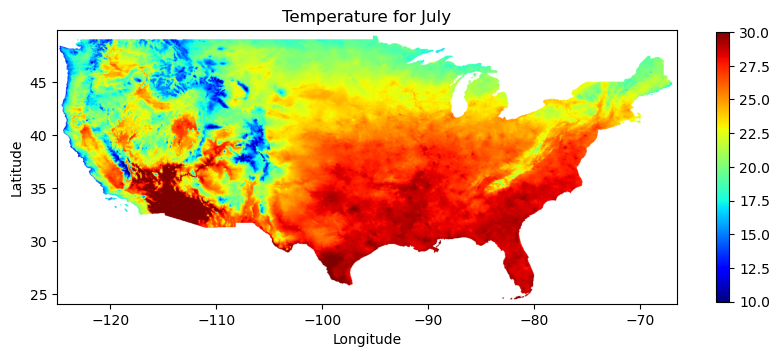

In [3]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

#s3_url = 's3://your-bucket-name/path/to/your/image.tif'
s3_url = 's3://ocs-training-2026/advanced/PRISM/unzipped/prism_tmean_us_25m_202507.tif'

# Open the raster file
with rasterio.open(f'{s3_url}') as src:
    # Read the temperature data from the first band
    temp = src.read(1)
    # Replace -9999 values with NaN
    temp[temp == -9999] = np.nan
    # Get the latitude and longitude coordinates
    lon_min, lat_min, lon_max, lat_max = src.bounds
    lat_res, lon_res = src.res
    lats = np.arange(lat_min, lat_max, lat_res)
    lons = np.arange(lon_min, lon_max, lon_res)
    lons, lats = np.meshgrid(lons, lats)

    # Set the minimum and maximum values of the color scale
    vmin = 10
    vmax = 30

    # Plot the temperature data with a color ramp
    cmap = plt.colormaps.get_cmap('jet')
    cmap.set_bad('white')

    # Set the size of the plot
    fig, ax = plt.subplots(figsize=(10, 7))

    # Plot the temperature data with a color ramp
    im = ax.imshow(temp, cmap=cmap, vmin=vmin, vmax=vmax, extent=[lons.min(), lons.max(), lats.min(), lats.max()])

    # Add a colorbar with a smaller size
    cbar = plt.colorbar(im, ax=ax, shrink=0.5)

    # Set the x and y axis labels
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    # Set the title of the plot
    ax.set_title('Temperature for July')

    # Show the plot
    plt.show()

### Step 4. Create a Data Cube (3D) with Random Numbers using `Zarr`
Let's take a step forward and move to multidimensional data. To create a cubic dataset with random numbers, we will import numpy, xarray, zarr, and pandas libraries. We will generate 720 latitudes from -90 to +90, 1440 longitudes from -180 to +180, and 365 days from 2023–01–01 to 2023–12–31. Next, we will create a 3D array with random numbers ranging from -20 to 30 and set time, latitude, and longitude. After that, we will convert the array to Xarray, save it in Zarr format, and label the data as "air temperature". The following lines do these steps for you:

In [4]:
import numpy as np
import xarray as xr
import pandas as pd
import s3fs
import zarr
import warnings #dont print warnings
warnings.filterwarnings('ignore')

# Set dimensions
lat = np.linspace(-90, 90, 720)
lon = np.linspace(-180, 180, 1440)
time = pd.date_range(start='2023-01-01', end='2023-12-31', freq='D')

# Create 3D array with random numbers
data = np.random.uniform(low=-20, high=30, size=(len(time), len(lat), len(lon)))

# Create xarray DataArray with coordinate labels
data_array = xr.DataArray(data, coords={"time": time, "lat": lat, "lon": lon}, dims=["time", "lat", "lon"])

# Use .to_dataset() function to convert the DataArray to a Dataset with the specified name
dataset = data_array.to_dataset(name="air_temperature")

### Write the random numbers data cube as a `zarr` datasets to an AWS S3 bucket
⚠️ **NOTE: THE FOLLOWING CODE BLOCK SAVES THE DATASET TO S3 AS A ZARR FILE. FOR SECURITY REASONS, WE HAVE REMOVED 'WRITE' ACCESS TO THE PUBLIC BUCKET USED IN THIS TRAINING. YOU CAN USE THIS CODE TO SAVE TO YOUR OWN S3 BUCKET WITHIN TNC's AWS ACCOUNT**

In [ ]:
import warnings #dont print warnings
warnings.filterwarnings('ignore')
# Initialize S3 File System
s3_out = s3fs.S3FileSystem() # Assumes credentials are set in environment/config

# Create an S3Map store for the target location
# Replace 'your-bucket-name' and 'path/to/your/file.zarr' with your actual S3 details
# s3_uri = 's3://your-bucket-name/path/to/your/dataset.zarr'
s3_uri = 's3://ocs-training-2026/advanced/random_data.zarr'
store = s3fs.S3Map(root=s3_uri, s3=s3_out, check=False)

# Write the Dataset to the S3 store as a Zarr file
# Use mode='w' to create a new store or overwrite an existing one
dataset.to_zarr(store=store, mode='w')

### Read the random numbers data cube `zarr` dataset from an existing AWS S3 bucket

In [ ]:
# The fsspec library is used under the hood to handle the S3 protocol and authentication
import fsspec
import xarray as xr
import zarr
import warnings #dont print warnings
warnings.filterwarnings('ignore')

# Define the S3 URL of the Zarr dataset
s3_uri = 's3://ocs-training-2026/advanced/random_data.zarr'

# Open the dataset with anonymous access for public datasets
# Here we are using the open_zarr function from the xarray library, which is a more direct and robust way to open Zarr datasets.
ds = xr.open_zarr(
    s3_uri,
    consolidated=True, # Optional: use if metadata is consolidated for faster opening
    storage_options={'anon': True} # Optional: use anonymous access for public datasets
)

# Alternatively, if you can also use the open_dataset function from the xarray library
#ds = xr.open_dataset("climate.zarr", chunks={}, engine="zarr")
da = ds["air_temperature"][:,:,:]
da

If the data cube is created correctly, you will see the variable name (in this case, air temperature) and dimensions for time (365), latitude (720), and longitude (1440). In the next section, we will use this data cube to plot it with Lexcube. But before that, let’s create a data cube with the climate data.

### Step 5. Create a Data Cube (3D) with Climate Data using `xarray`

To create the data cube with climate data, we will use the GeoTIFF files from the PRISM climate datasets pre-downloaded for this training. You should have the mean air temperature of the US for July from 2000 to 2025 in GeoTIFF format in your content folder. Before reading the raster files in a loop, we need to create a list of date ranges for those GeoTIFF files, as the GeoTIFF files cover July from 2000 to 2025. Next, we will read each raster file using the rasterio package, convert the raster file to Xarray with latitude and longitude extracted from each file, and create a data cube by appending the 2D data from each raster file. Finally, we’ll set the time in the data cube based on the time range we generated and save it as a Zarr file:

In [10]:
import rasterio
import xarray as xr
import os
import pandas as pd
import numpy as np
import s3fs

# Create a time list
time = pd.date_range(start='2000-07-01', end='2025-07-01', freq='YS-JUL')

# Read raster files and create a list of xarray DataArrays
data_arrays = []
for file in geotiff_files:
    with rasterio.open(os.path.join('s3://', s3_bucket_name, file)) as src:
        data = src.read(1)  # Read the first band
        height, width = src.shape
        y_values = np.arange(height) * src.transform[4] + src.transform[5]
        x_values = np.arange(width) * src.transform[0] + src.transform[2]
        da = xr.DataArray(data, dims=("y", "x"), coords={"y": y_values, "x": x_values}, name="air_temperature")
        data_arrays.append(da)

# Combine DataArrays into a single xarray Dataset
ds = xr.concat(data_arrays, dim="time")
ds["time"] = ("time", time)  # Assign month numbers as time coordinates
ds

<xarray.DataArray 'air_temperature' (time: 26, y: 621, x: 1405)> Size: 91MB
array([[[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        ...,
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.]],

       [[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        ...,
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.]],

       [[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        ...,
...
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.]],

       [[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        ...,
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.]],

       [[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        ...,
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.]]],
      shape=(26, 621, 1405), dtype=float32)
Coordinates:
  * time     (time) datetime64[us] 208B 2000-07-01 2001-07-01 ... 2025-07-01
  * y        (y) float64 5kB 49.94 49.9 49.85 49.81 ... 24.23 24.19 24.15 24.1
  * x        (x) float64 11kB -125.0 -125.0 -124.9 ... -66.6 -66.56 -66.52

### Write the climate data cube as a `zarr` dataset to an AWS S3 bucket
⚠️ **NOTE: THE FOLLOWING CODE BLOCK SAVES THE DATASET TO S3 AS A ZARR FILE. FOR SECURITY REASONS, WE HAVE REMOVED 'WRITE' ACCESS TO THE PUBLIC BUCKET USED IN THIS TRAINING. YOU CAN USE THIS CODE TO SAVE TO YOUR OWN S3 BUCKET WITHIN TNC's AWS ACCOUNT**

In [11]:
import zarr
import warnings #dont print warnings
warnings.filterwarnings('ignore')
# Initialize S3 File System
s3_out = s3fs.S3FileSystem() # Assumes credentials are set in environment/config

# Create an S3Map store for the target location
# Replace 'your-bucket-name' and 'path/to/your/file.zarr' with your actual S3 details
# s3_uri = 's3://your-bucket-name/path/to/your/dataset.zarr'
s3_uri = 's3://ocs-training-2026/advanced/PRISM/climate.zarr'
store = s3fs.S3Map(root=s3_uri, s3=s3_out, check=False)

# Write the Dataset to the S3 store as a Zarr file
# Use mode='w' to create a new store or overwrite an existing one
dataset.to_zarr(store=store, mode='w')

### Read the climate data cube as a `zarr` dataset from an existing AWS S3 bucket
Similar to the previous section, we can read the saved Zarr file using the following:

In [13]:
# The fsspec library is used under the hood to handle the S3 protocol and authentication
import fsspec
import xarray as xr
import zarr
import warnings #dont print warnings
warnings.filterwarnings('ignore')

# Define the S3 URL of the Zarr dataset
s3_uri = 's3://ocs-training-2026/advanced/PRISM/climate.zarr'

# Open the dataset with anonymous access for public datasets
# Here we are using the open_zarr function from the xarray library, which is a more direct and robust way to open Zarr datasets.
ds = xr.open_zarr(
    s3_uri,
    consolidated=True, # Optional: use if metadata is consolidated for faster opening
    storage_options={'anon': True} # Optional: use anonymous access for public datasets
)

# Alternatively, if you can also use the open_dataset function from the xarray library
#ds = xr.open_dataset("climate.zarr", chunks={}, engine="zarr")
da = ds["air_temperature"][:,:,:]
da

<xarray.DataArray 'air_temperature' (time: 365, lat: 720, lon: 1440)> Size: 3GB
dask.array<open_dataset-air_temperature, shape=(365, 720, 1440), dtype=float64, chunksize=(23, 90, 180), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 3kB 2023-01-01 2023-01-02 ... 2023-12-31
  * lat      (lat) float64 6kB -90.0 -89.75 -89.5 -89.25 ... 89.5 89.75 90.0
  * lon      (lon) float64 12kB -180.0 -179.7 -179.5 ... 179.5 179.7 180.0

If the file is saved correctly, you should see the Xarray details (26 layers in time, 1405 grids on the x-axis, and 621 grids on the y-axis).

### Step 6. 3D Visualization of `Xarray` and `zarr` by `Lexcube`
Let's now use the [lexcube package](https://github.com/msoechting/lexcube) to create some nifty 3D visualizations. Now that we have two Zarr files (one based on random numbers and the second based on climate data), we are ready to plot the 3D visualization of these two data cubes. To have a better and more meaningful 3D plot, let’s visualize the second data cube (climate data).

In [16]:
import fsspec
import xarray as xr
import zarr

# Define the S3 URL of the Zarr dataset
s3_uri = 's3://ocs-training-2026/advanced/PRISM/climate.zarr/'

# Open the dataset with anonymous access for public datasets
# Here we are using the open_zarr function from the xarray library, which is a more direct and robust way to open Zarr datasets.
ds = xr.open_zarr(
    s3_uri,
    consolidated=True, # Optional: use if metadata is consolidated for faster opening
    storage_options={'anon': True} # Optional: use anonymous access for public datasets
)

da = ds["air_temperature"][:,:,:]

##### This may fail in certain testing environments due to missing notebook widgets
import lexcube 
w = lexcube.Cube3DWidget(da,cmap="RdYlBu_r", vmin=0, vmax=30)
w

Cube3DWidget(api_metadata={'/api': {'status': 'ok', 'api_version': 5}, '/api/datasets': [{'id': 'default', 'sh…

### BONUS Exercise: Let’s zoom in on a given area and look at the mean air temperature for July 2025 displayed on the top layer. Additionally, by hovering your mouse over the latitude and longitude axes, you can see the air temperature for different years. Which year was the warmest? At which coordinates?

### Step 7. What Else Can We Do with Lexcube?
Let’s assume you want to clip this plot for a specific location (latitude and longitude) and a specific time. Instead of manually zooming in and out on each axis, which is not very convenient, you can activate the slider by running the following:

In [ ]:
w.show_sliders()

with that slider, you can clip your plot for any location and timeframe.

And last but not least, if you want to save the plot in your local folder, you can do so by running the following:

In [ ]:
w.savefig(fname="climate.png", include_ui=True, dpi_scale=2.0)

The PNG file will be saved in your folder. If you want to change the color ramp, Lexcube supports many color maps that you can find in the GitHub repository mentioned in the reference section.

## 📚 References and Additional Resources
M., Söchting, M. D., Mahecha, D., Montero, and G., Scheuermann, Lexcube: Interactive Visualization of Large Earth System Data Cubes (2023). IEEE Computer Graphics and Applications. doi:10.1109/MCG.2023.3321989.

[https://github.com/msoechting/lexcube](https://github.com/msoechting/lexcube)

[https://pubmed.ncbi.nlm.nih.gov/37812545/](https://pubmed.ncbi.nlm.nih.gov/37812545/)

[https://eo4society.esa.int/2022/05/25/exploring-earth-system-data-with-lexcube/](https://eo4society.esa.int/2022/05/25/exploring-earth-system-data-with-lexcube/)

[https://www.linkedin.com/posts/miguel-mahecha-625548197_lexcube-activity-7156200204700966913-5lOb?utm_source=share&utm_medium=member_desktop](https://www.linkedin.com/posts/miguel-mahecha-625548197_lexcube-activity-7156200204700966913-5lOb?utm_source=share&utm_medium=member_desktop)

PRISM Climate Group, Oregon State University, [https://prism.oregonstate.edu](https://prism.oregonstate.edu), date created 1981–2022, accessed 19 Dec 2024.